
# SCHISM procedural example

In this notebook we will use the SCHOSM grid, config and data objects to define a SCHISM workspace

In [1]:
%load_ext autoreload
%autoreload 2

# turn off warnings
import warnings
warnings.filterwarnings('ignore')

import sys
from datetime import datetime
from pathlib import Path
from rompy.core import DataBlob, TimeRange
from shutil import rmtree
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import intake
import cartopy.crs as ccrs

import logging
logging.basicConfig(level=logging.INFO)

HERE = Path('../../tests/schism')


### Workspace basepath

In [2]:
workdir = Path("schism_procedural")
if workdir.exists():
    rmtree(workdir)

workdir.mkdir(exist_ok=True)

### Model Grid

In [34]:
# Grid object

from rompy.schism import Inputs, SCHISMGrid

#SCHISMGrid?

# Medium sized grid, will run one day in about 3 minutes on 48 cores
# hgrid = HERE / "test_data" / "hgrid.gr3"

# Fast running grid, will run in about 1 minute on 4 cores
hgrid = HERE / "test_data" / "hgrid_20kmto60km_rompyschism_testing.gr3"

grid=SCHISMGrid(
    hgrid=DataBlob(id="hgrid", source=HERE / "test_data" / hgrid),
    drag=1,
)

grid.plot_hgrid()

FileNotFoundError: [Errno 2] No such file or directory: '../../tests/schism/test_data/../../tests/schism/test_data/hgrid_20kmto60km_rompyschism_testing.gr3'

In [4]:
grid.get(workdir)
list(workdir.glob('*'))

INFO:rompy.schism.grid:Generated albedo with constant value of 0.15
INFO:rompy.schism.grid:Generated diffmin with constant value of 1e-06
INFO:rompy.schism.grid:Generated diffmax with constant value of 1.0
INFO:rompy.schism.grid:Generated watertype with constant value of 1.0
INFO:rompy.schism.grid:Generated windrot_geo2proj with constant value of 0.0
INFO:rompy.schism.grid:Generated drag with constant value of 1.0
INFO:rompy.schism.grid:Linking hgrid.gr3 to schism_procedural/hgrid.ll
INFO:rompy.schism.grid:Linking hgrid.gr3 to schism_procedural/hgrid_WWM.gr3


[PosixPath('schism_procedural/hgrid.gr3'),
 PosixPath('schism_procedural/hgrid.ll'),
 PosixPath('schism_procedural/diffmin.gr3'),
 PosixPath('schism_procedural/watertype.gr3'),
 PosixPath('schism_procedural/vgrid.in'),
 PosixPath('schism_procedural/albedo.gr3'),
 PosixPath('schism_procedural/windrot_geo2proj.gr3'),
 PosixPath('schism_procedural/wwmbnd.gr3'),
 PosixPath('schism_procedural/diffmax.gr3'),
 PosixPath('schism_procedural/drag.gr3'),
 PosixPath('schism_procedural/hgrid_WWM.gr3'),
 PosixPath('schism_procedural/tvd.prop')]


# Forcing data

In [5]:
# First lists import the main data classes
from rompy.schism.data import SCHISMDataSflux, SCHISMDataOcean, SCHISMDataWave, SCHISMDataTides

# Sets also import a few of the minor classes that are used in the construction of these main classes for use in this demo
from rompy.schism.data import SfluxSource, TidalDataset, SfluxAir, SCHISMDataBoundary

# And also lets import some of the core data source objects. These are data input abstractions that work in exactly the same way as 
# with the swan classes, and can be used interchangeably in each of the data classes depending on the data source. We will use a 
# bit of a mix here for illustration purposes.
from rompy.core.data import DataBlob, SourceFile, SourceDataset, SourceIntake, SourceDatamesh
from rompy.core.boundary import SourceWavespectra

### Sflux Data

In [6]:
from rompy.schism.namelists import Sflux_Inputs
# SCHISMDataSflux??
# SfluxSource??
# Sflux_Inputs??



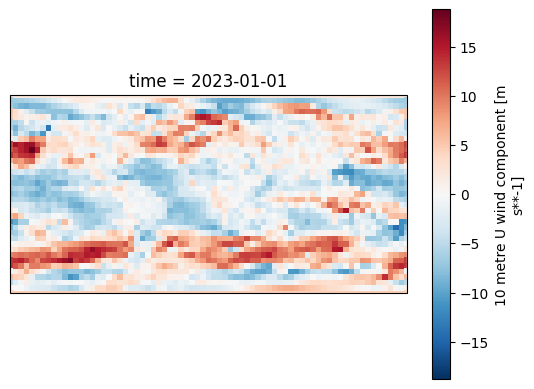

In [7]:
import intake
cat = intake.open_catalog(HERE / ".." / "data" / "catalog.yaml")
ds = cat.era5.to_dask()
ax = plt.axes(projection=ccrs.PlateCarree())
ds.u10[0].plot(ax=ax, transform=ccrs.PlateCarree(), cmap="RdBu_r")

In [8]:
# Lets have a look at an flux object. Here we will use a ERA5 dataset exposed through the intake catalog in the tests/data folder.
from rompy.core.time import TimeRange

atmos_forcing = SCHISMDataSflux(
    air_1=SfluxAir(
        id="air_1",
        source=SourceIntake(
            dataset_id="era5",
            catalog_uri=HERE / ".." / "data" / "catalog.yaml",
        ),
        filter={
            "sort": {"coords": ["latitude"]},
        },
    buffer=2
    )
)
atmos_forcing.get(destdir=workdir, grid=grid, time=TimeRange(start="2023-01-01", end="2023-01-02", dt=3600))

INFO:rompy.schism.data:Fetching air_1


In [9]:
list(workdir.glob('**/*'))



[PosixPath('schism_procedural/hgrid.gr3'),
 PosixPath('schism_procedural/hgrid.ll'),
 PosixPath('schism_procedural/diffmin.gr3'),
 PosixPath('schism_procedural/watertype.gr3'),
 PosixPath('schism_procedural/vgrid.in'),
 PosixPath('schism_procedural/albedo.gr3'),
 PosixPath('schism_procedural/sflux'),
 PosixPath('schism_procedural/windrot_geo2proj.gr3'),
 PosixPath('schism_procedural/wwmbnd.gr3'),
 PosixPath('schism_procedural/diffmax.gr3'),
 PosixPath('schism_procedural/drag.gr3'),
 PosixPath('schism_procedural/hgrid_WWM.gr3'),
 PosixPath('schism_procedural/tvd.prop'),
 PosixPath('schism_procedural/sflux/air_1.0001.nc'),
 PosixPath('schism_procedural/sflux/sflux_inputs.txt')]

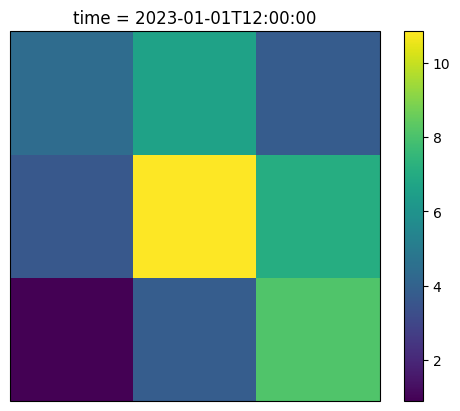

In [10]:
# Create a map
ax = plt.axes(projection=ccrs.PlateCarree())
# load the data
ds = xr.open_dataset("schism_procedural/sflux/air_1.0001.nc")
wind_speed = np.sqrt(ds.u10**2 + ds.v10**2)
# plot the data
wind_speed.isel(time=2).plot(ax=ax, transform=ccrs.PlateCarree())


### Ocean Boundary

In [11]:
#SCHISMDataOcean??

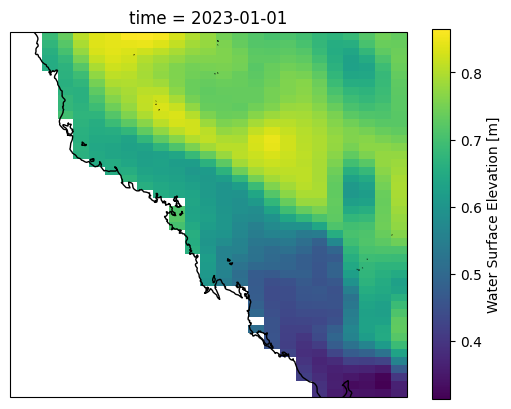

In [12]:
ds = xr.open_dataset(HERE / "test_data" / "hycom.nc")
ax = plt.axes(projection=ccrs.PlateCarree())
ds["surf_el"].isel(time=0).plot(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()

In [13]:

ocean_forcing = SCHISMDataOcean(
                elev2D = SCHISMDataBoundary(
                    id="hycom",
                    source=SourceFile(
                        uri=HERE / "test_data" / "hycom.nc",
                    ),
                    variable="surf_el",
                    coords={"t": "time", "y": "ylat", "x": "xlon", "z": "depth"},
                    interpolate_missing_coastal=True,
                    ),
                )



In [14]:
ocean_forcing.get(destdir=workdir, grid=grid)
list(workdir.glob("*"))



INFO:rompy.schism.data:Fetching elev2D


[PosixPath('schism_procedural/hgrid.gr3'),
 PosixPath('schism_procedural/hgrid.ll'),
 PosixPath('schism_procedural/diffmin.gr3'),
 PosixPath('schism_procedural/watertype.gr3'),
 PosixPath('schism_procedural/vgrid.in'),
 PosixPath('schism_procedural/albedo.gr3'),
 PosixPath('schism_procedural/sflux'),
 PosixPath('schism_procedural/windrot_geo2proj.gr3'),
 PosixPath('schism_procedural/wwmbnd.gr3'),
 PosixPath('schism_procedural/diffmax.gr3'),
 PosixPath('schism_procedural/elev2D.th.nc'),
 PosixPath('schism_procedural/drag.gr3'),
 PosixPath('schism_procedural/hgrid_WWM.gr3'),
 PosixPath('schism_procedural/tvd.prop')]

In [15]:
dsb = xr.open_dataset('schism_procedural/elev2D.th.nc')
dsb.time[0]

<xarray.DataArray 'time' ()>
array('2023-01-01T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2023-01-01
Attributes:
    long_name:      Time
    standard_name:  time
    base_date:      [2023    1    1    0    0    0]

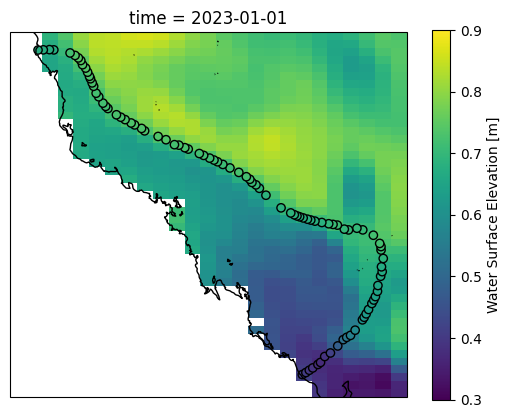

In [16]:
vmin, vmax = 0.3, 0.9
time = dsb.time[0]
ax = plt.axes(projection=ccrs.PlateCarree())
ds["surf_el"].sel(time=time).plot(ax=ax, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax)
ax.coastlines()
values = dsb.time_series.isel(time=0)
x,y = grid.boundary_points()
ax.scatter(x, y, transform=ccrs.PlateCarree(), c=values, cmap="viridis", vmin=vmin, vmax=vmax, edgecolor="black")

# Check for nans (there shouldn't be any)
# nans = dsb.time_series.isel(time=0).isnull().squeeze()
# ax.scatter(x[nans], y[nans], transform=ccrs.PlateCarree(), c="red", edgecolor="black")

### Wave

In [17]:
# SCHISMDataWave??

In [18]:
wave_forcing = SCHISMDataWave(
        id="wavedata",
        source=SourceIntake(
            dataset_id="ausspec",
            catalog_uri=HERE / ".." / "data" / "catalog.yaml",
        ),
        coords={'x': "lon", 'y': "lat"},
)


<GeoAxes: >

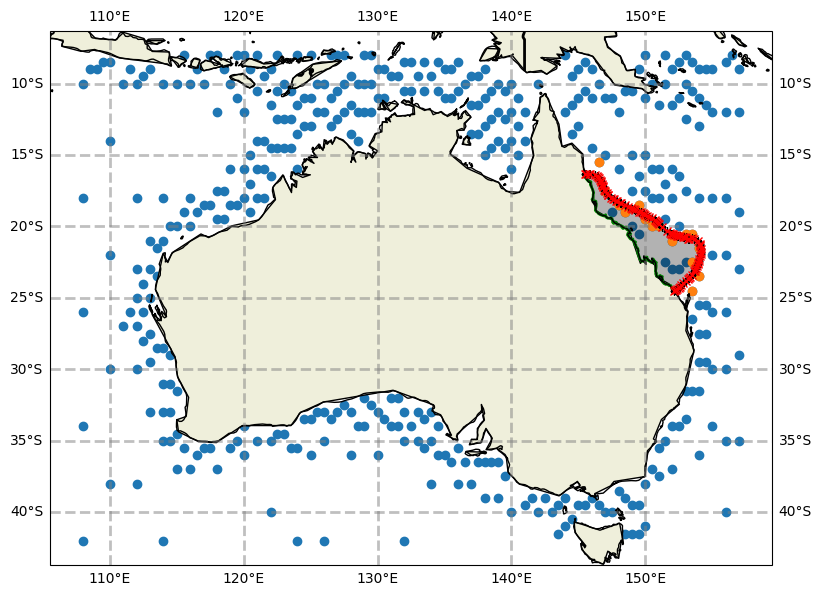

In [19]:
ax = wave_forcing.plot(model_grid=grid)
wave_forcing.plot_boundary(ax=ax, grid=grid)

### Tidal data

In [20]:
# SCHISMDataTides?
# TidalDataset?

In [21]:
tidal_forcing = SCHISMDataTides(
    tidal_data=TidalDataset(
        elevations=HERE / "test_data"/ "tpxo9-test" / "h_m2s2n2.nc",
        velocities=HERE / "test_data"/ "tpxo9-test" / "u_m2s2n2.nc" 
    ),
    constituents=["M2", "S2", "N2"],
)
tidal_forcing.get(
    destdir=workdir,
    grid=grid,
    time=TimeRange(start="2023-01-01", end="2023-01-02", dt=3600),
)



INFO:rompy.schism.data:Generating tides
INFO:pyschism.forcing.bctides.bctides:Processing boundary 1:
INFO:pyschism.forcing.bctides.bctides:Elevation type: 5
INFO:pyschism.forcing.bctides.tpxo:Querying TPXO for elevation constituent M2.
INFO:pyschism.forcing.bctides.tpxo:Querying TPXO for elevation constituent S2.
INFO:pyschism.forcing.bctides.tpxo:Querying TPXO for elevation constituent N2.
INFO:pyschism.forcing.bctides.bctides:Velocity type: 3
INFO:pyschism.forcing.bctides.tpxo:Querying TPXO for velocity constituent M2.
INFO:pyschism.forcing.bctides.tpxo:Querying TPXO for velocity constituent S2.
INFO:pyschism.forcing.bctides.tpxo:Querying TPXO for velocity constituent N2.
INFO:pyschism.forcing.bctides.bctides:Temperature type: 0
INFO:pyschism.forcing.bctides.bctides:Salinity type: 0
INFO:pyschism.forcing.bctides.bctides:Salinity is not sepcified, not input needed!


# Full config object

In [22]:

# Instantiate a config object

from rompy.schism import SchismCSIROConfig
from rompy.schism.data import SCHISMData
from pydantic import ValidationError
try:
    config=SchismCSIROConfig(
        grid=grid,
        data=SCHISMData(
            atmos=atmos_forcing, 
            ocean=ocean_forcing, 
            wave=wave_forcing, 
            tides=tidal_forcing
            ),
    )
except ValidationError as e:
    print(e)

1 validation error for SchismCSIROConfig
  Value error, manning.gr3 must be specified when nchi=-1 [type=value_error, input_value={'grid': SCHISMGrid([145....], sobc=[1], relax=[]))}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.5/v/value_error


In [23]:
# That gives us an expected error due to teh fact that we have a validator checking required inputs
# Lets fix the grid issue and try again

try:
    config=SchismCSIROConfig(
        grid=grid,
        data=SCHISMData(
            atmos=atmos_forcing, 
            ocean=ocean_forcing, 
            wave=wave_forcing, 
            tides=tidal_forcing
            ),
    )
except ValidationError as e:
    print(e)


# Again we get a validation error, the hgrid_WWM is missing. Lets add it and try again

grid=SCHISMGrid(
    hgrid=DataBlob(id="hgrid", source=HERE / "test_data" / "hgrid.gr3"),
    manning=1,
)
config=SchismCSIROConfig(
    grid=grid,
    mesbf=1,
    fricc=0.067,
    data=SCHISMData(
        atmos=atmos_forcing, 
        ocean=ocean_forcing, 
        wave=wave_forcing, 
        tides=tidal_forcing
        ),
)


1 validation error for SchismCSIROConfig
  Value error, manning.gr3 must be specified when nchi=-1 [type=value_error, input_value={'grid': SCHISMGrid([145....], sobc=[1], relax=[]))}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.5/v/value_error


In [24]:
# config.model_dump()

In [25]:
config.data

SCHISMData(data_type='schism', atmos=SCHISMDataSflux(data_type='sflux', air_1=SfluxAir(model_type='data_grid', id='air_1', source=SourceIntake(model_type='intake', dataset_id='era5', catalog_uri=PosixPath('../../tests/schism/../data/catalog.yaml'), kwargs={}), filter=Filter(sort={'coords': ['latitude']}, subset={}, crop={'longitude': Slice(start=143.4089758468, stop=156.1664617424), 'latitude': Slice(start=-26.529484917, stop=-14.3399080571), 'time': Slice(start=datetime.datetime(2023, 1, 1, 0, 0), stop=datetime.datetime(2023, 1, 2, 0, 0))}, timenorm={}, rename={}, derived={}), variables=[], coords=DatasetCoords(t='time', x='longitude', y='latitude', z='depth'), crop_data=True, buffer=2.0, data_type='sflux_air', relative_weight=1.0, max_window_hours=120.0, fail_if_missing=True, uwind_name='u10', vwind_name='v10', prmsl_name='mslp', stmp_name='stmp', spfh_name='spfh'), air_2=None, rad_1=None, rad_2=None, prc_1=None, prc_2=None), ocean=SCHISMDataOcean(data_type='ocean', elev2D=SCHISMData

# Model Run

Note  that most fields are optional, this eample using defaults values.


### Generate workspace


In [26]:
if workdir.exists():
    rmtree(workdir)

workdir.mkdir(exist_ok=True)

from rompy.model import ModelRun
from rompy.schism import SchismCSIROConfig

run = ModelRun(
    run_id="test_schism",
    period=TimeRange(start=datetime(2023, 1, 1, 0), end=datetime(2023, 1, 2, 0), interval="1h"),
    output_dir=str(workdir),
    config=config
)

rundir = run()


INFO:rompy.model:
INFO:rompy.model:-----------------------------------------------------
INFO:rompy.model:Model settings:
INFO:rompy.model:
run_id: test_schism
period: 
	Start: 2023-01-01 00:00:00
	End: 2023-01-02 00:00:00
	Duration: 1 day, 0:00:00
	Interval: 1:00:00
	Include End: True

output_dir: schism_procedural
config: <class 'rompy.schism.config.SchismCSIROConfig'>

INFO:rompy.model:-----------------------------------------------------
INFO:rompy.model:Generating model input files in schism_procedural
INFO:rompy.schism.grid:Generated albedo with constant value of 0.15
INFO:rompy.schism.grid:Generated diffmin with constant value of 1e-06
INFO:rompy.schism.grid:Generated diffmax with constant value of 1.0
INFO:rompy.schism.grid:Generated watertype with constant value of 1.0
INFO:rompy.schism.grid:Generated windrot_geo2proj with constant value of 0.0
INFO:rompy.schism.grid:Generated manning with constant value of 1.0
INFO:rompy.schism.grid:Linking hgrid.gr3 to schism_procedural/test

### Run schism

In [27]:
!cd schism_procedural/test_schism && mpirun -np 4 /source/schism/src/_VL_WWM 1 

   0: ABORT:  QUICKSEARCH: Cannot find a vert. level:                       NaN   6.9527172220588185E-310   6.9527172219822878E-310  -136.46091878924517                            NaN                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [28]:
import yaml
# dump full model to yaml
with open('model.yaml', 'w') as f:
    yaml.dump(run.model_dump(), f)


In [29]:
!cat model.yaml

config:
  CGPP: F
  CPP: F
  DM: T
  DPEAK: T
  DSPR: T
  HS: T
  KPP: F
  LPP: F
  ORBITAL: F
  PEAKD: T
  PEAKDSPR: T
  TM01: T
  TM02: F
  TPP: T
  TPPD: T
  UBOT: F
  WNPP: F
  ac: T
  brcrYN: ''
  checkout: main
  currYN: '!'
  data:
    atmos:
      air_1:
        buffer: 2.0
        coords:
          t: time
          x: longitude
          y: latitude
          z: depth
        crop_data: true
        data_type: sflux_air
        fail_if_missing: true
        filter:
          crop:
            latitude:
              start: -26.529484917
              stop: -14.3399080571
            longitude:
              start: 143.4089758468
              stop: 156.1664617424
            time:
              start: &id001 2023-01-01 00:00:00
              stop: &id002 2023-01-02 00:00:00
          derived: {}
          rename: {}
          sort:
            coords:
            - latitude
          subset: {}
          timenorm: {}
        id: air_1
        max_window_hours: 120.0
        m

### Check the workspace

In [30]:
list(Path(rundir).glob("*"))

[PosixPath('/source/rompy/notebooks/schism/schism_procedural/test_schism/wwm_hist.nc'),
 PosixPath('/source/rompy/notebooks/schism/schism_procedural/test_schism/bctides.in'),
 PosixPath('/source/rompy/notebooks/schism/schism_procedural/test_schism/hgrid.gr3'),
 PosixPath('/source/rompy/notebooks/schism/schism_procedural/test_schism/datasets'),
 PosixPath('/source/rompy/notebooks/schism/schism_procedural/test_schism/wwmcheck.nml'),
 PosixPath('/source/rompy/notebooks/schism/schism_procedural/test_schism/README'),
 PosixPath('/source/rompy/notebooks/schism/schism_procedural/test_schism/hgrid.ll'),
 PosixPath('/source/rompy/notebooks/schism/schism_procedural/test_schism/wwminput.nml'),
 PosixPath('/source/rompy/notebooks/schism/schism_procedural/test_schism/diffmin.gr3'),
 PosixPath('/source/rompy/notebooks/schism/schism_procedural/test_schism/watertype.gr3'),
 PosixPath('/source/rompy/notebooks/schism/schism_procedural/test_schism/vgrid.in'),
 PosixPath('/source/rompy/notebooks/schism/sc

In [31]:
!cat demo.yaml

output_dir: schism_declaritive
period:
  start: 20230101T00
  end: 20230102T00
  interval: 3600
run_id: test_schism
config:
  model_type: schismcsiro
  mesbf: 1
  fricc: 0.067
  grid:
    grid_type: schism
    hgrid:
      id: hgrid
      model_type: data_blob
        #source: ../../tests/schism/test_data/hgrid.gr3
      source: ../../tests/schism/test_data/hgrid_20kmto60km_rompyschism_testing.gr3
    manning: 1
    # manning:
    #   model_type: data_blob
    #   source: ../../tests/schism/test_data/manning.gr3
    # hgrid_WWM:
    #   model_type: data_blob
    #   source: ../../tests/schism/test_data/hgrid_WWM.gr3
    # wwmbnd:
    #   model_type: data_blob
    #   source: ../../tests/schism/test_data/wwmbnd.gr3
  data:
    data_type: schism
    atmos:
      air_1:
        source: 
          uri:  ../../tests/schism/test_data/atmos.nc
          model_type: open_dataset
        uwind_name: u10
        vwind_name: v10
        prml_name: mslp
        filter:
          sort: {coords: [la

In [32]:
demo_config = yaml.load(open('demo.yaml', 'r'), Loader=yaml.FullLoader)

In [33]:
run = ModelRun(**demo_config)